# SARIMA - Season Autoregressive Moving Average Model
Author: Geovanna Santos Nobre de Oliveira

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

## Import data

In [3]:
path = '../../00_data'

In [4]:
data = pd.read_csv(f'{path}/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


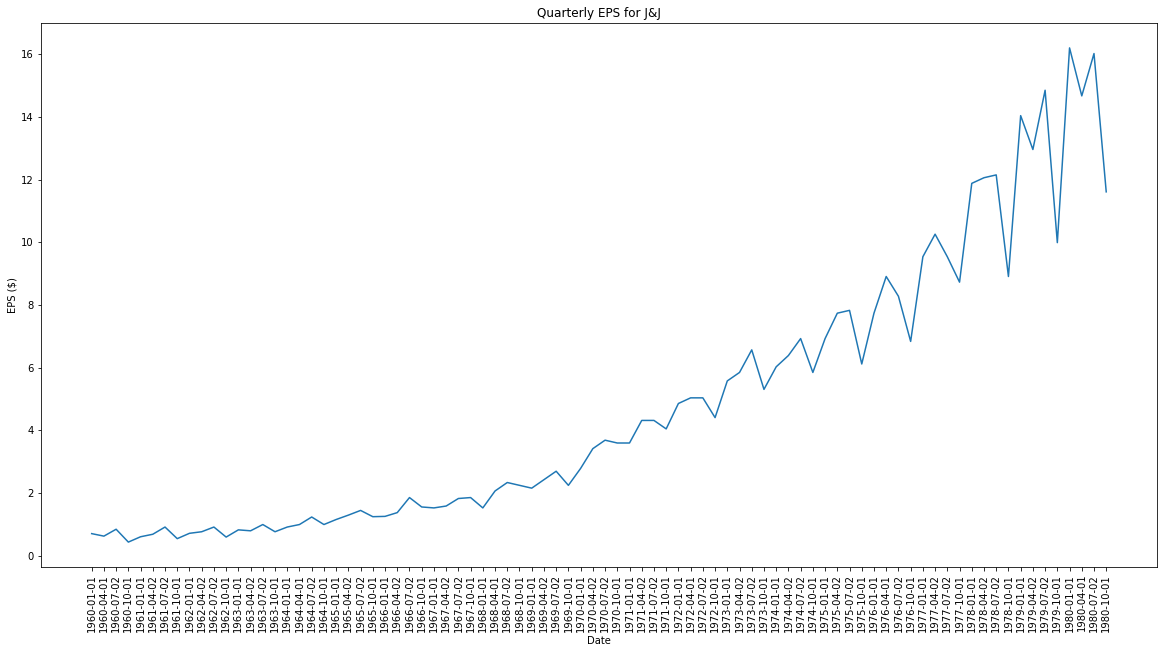

In [5]:
plt.plot(
    data['date'],
    data['data']
)
plt.title('Quarterly EPS for J&J')
plt.ylabel('EPS ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

In [6]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


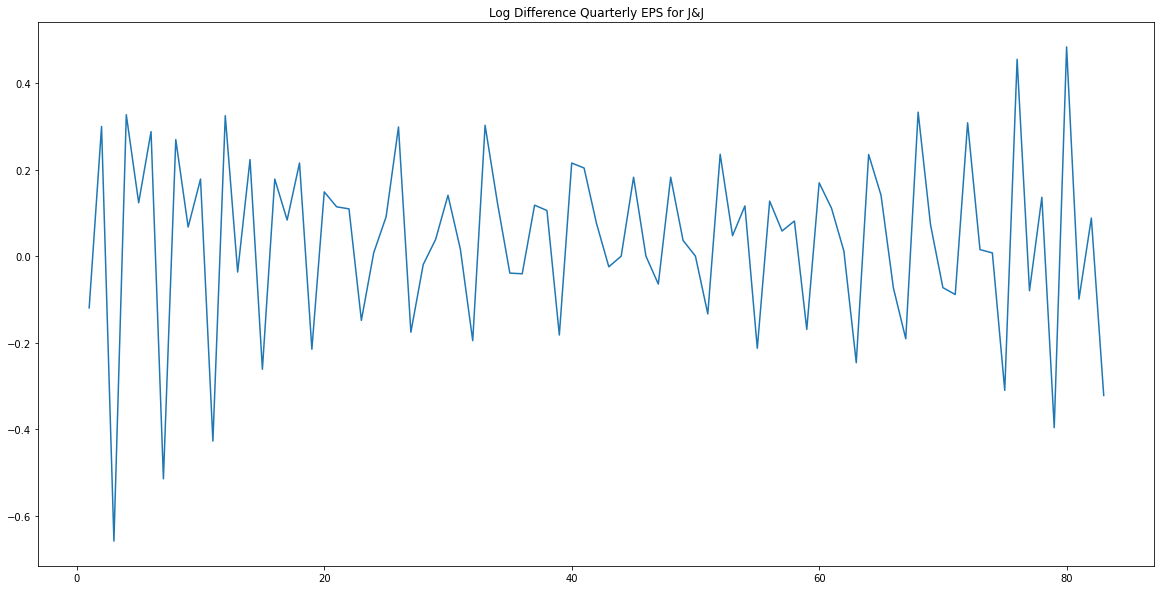

In [11]:
plt.plot(data['data_tr_1'][1:])
plt.title('Log Difference Quarterly EPS for J&J')
plt.show()

In [9]:
data['data_tr_2'] = data['data_tr_1'][1:].diff(4)
data.head(15)

,date,data,data_tr_1,data_tr_2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006
8,1962-01-01,0.72,0.269333,-0.057351
9,1962-04-02,0.77,0.067139,-0.056093


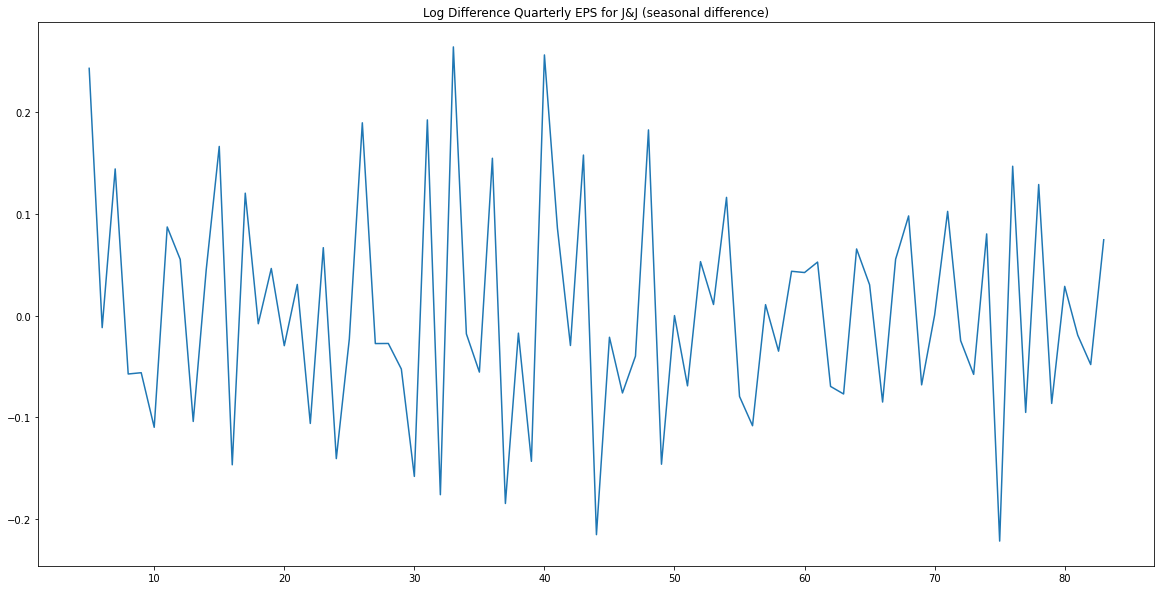

In [12]:
plt.plot(data['data_tr_2'][5:])
plt.title('Log Difference Quarterly EPS for J&J (seasonal difference)')
plt.show()

In [13]:
ad_fuller_result = adfuller(data['data_tr_2'][5:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914263
p-value: 5.72157869513621e-09


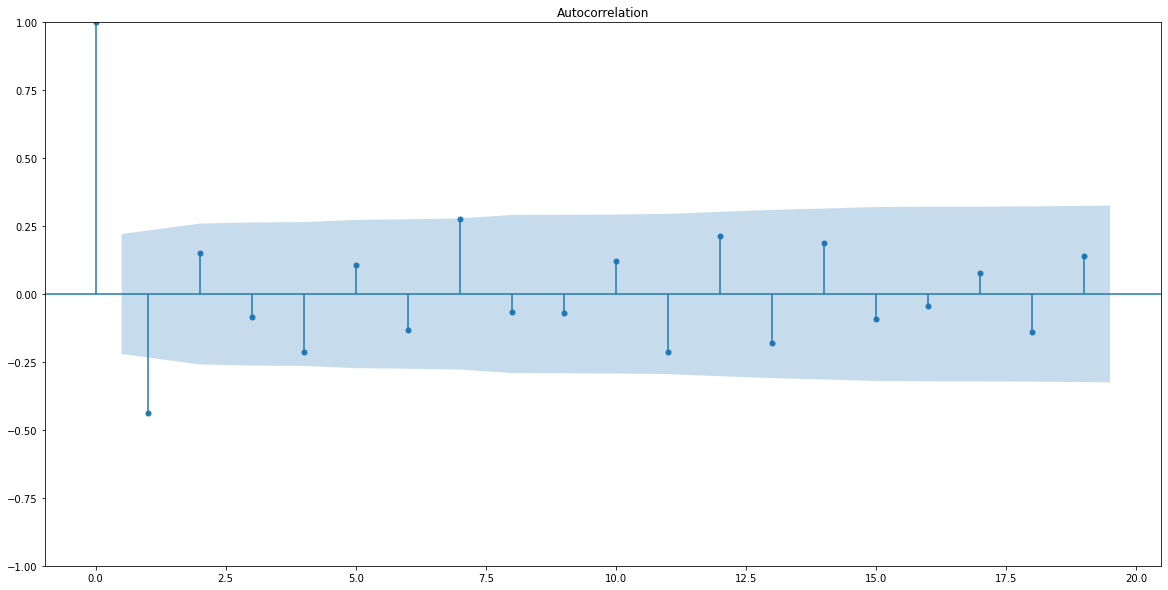

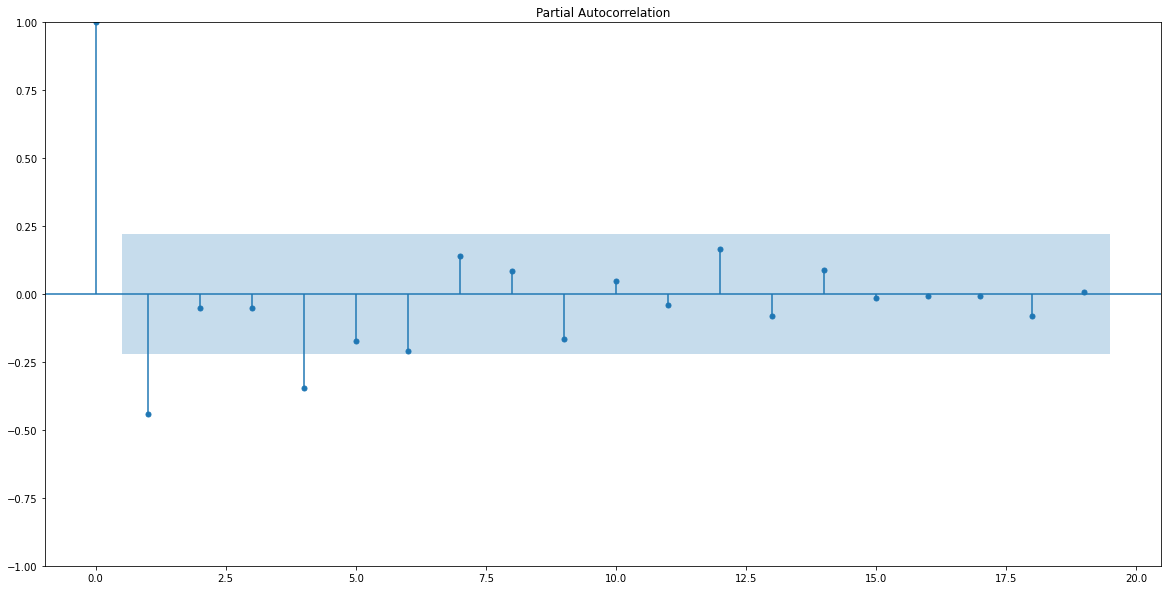

In [14]:
plot_acf(data['data_tr_2'][5:]);
plot_pacf(data['data_tr_2'][5:]);

In [15]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Returns dataframe with parameters and corresponding AIC

        Args:
            endog : the observed variables
            parameters_list : list with (p, q, P, Q) tuples
            d : integration order
            D : seasonol integration order
            s : length of a season
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(
                endog,
                order = (param[0], d, param[1]),
                seasonal_order= (param[2], D, param[3], s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue
        
        aic = model.aic 
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q) x (P,Q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)

P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)

s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0)]


In [19]:
result_df = optimize_SARIMA(data['data'], parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q) x (P,Q)",AIC
0,"(2, 3, 0, 0)",92.586926
1,"(2, 3, 1, 0)",93.976696
2,"(2, 3, 0, 1)",94.130645
3,"(3, 3, 0, 0)",94.468460
4,"(2, 3, 0, 2)",95.169661
...,...,...
251,"(0, 0, 3, 1)",144.211575
252,"(0, 0, 3, 3)",145.086446
253,"(0, 0, 2, 3)",145.465206
254,"(0, 0, 3, 2)",145.563922


In [20]:
best_model = SARIMAX(
    data['data'],
    order = (2,1,3),
    seasonal_order= (0,1,0,4),
    simple_differencing=False
)
res = best_model.fit(disp=False)

print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 4)   Log Likelihood                 -40.293
Date:                            Tue, 05 Jul 2022   AIC                             92.587
Time:                                    15:41:36   BIC                            106.804
Sample:                                         0   HQIC                            98.283
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4837      0.116    -12.808      0.000      -1.711      -1.257
ar.L2         -0.7895      0.131   

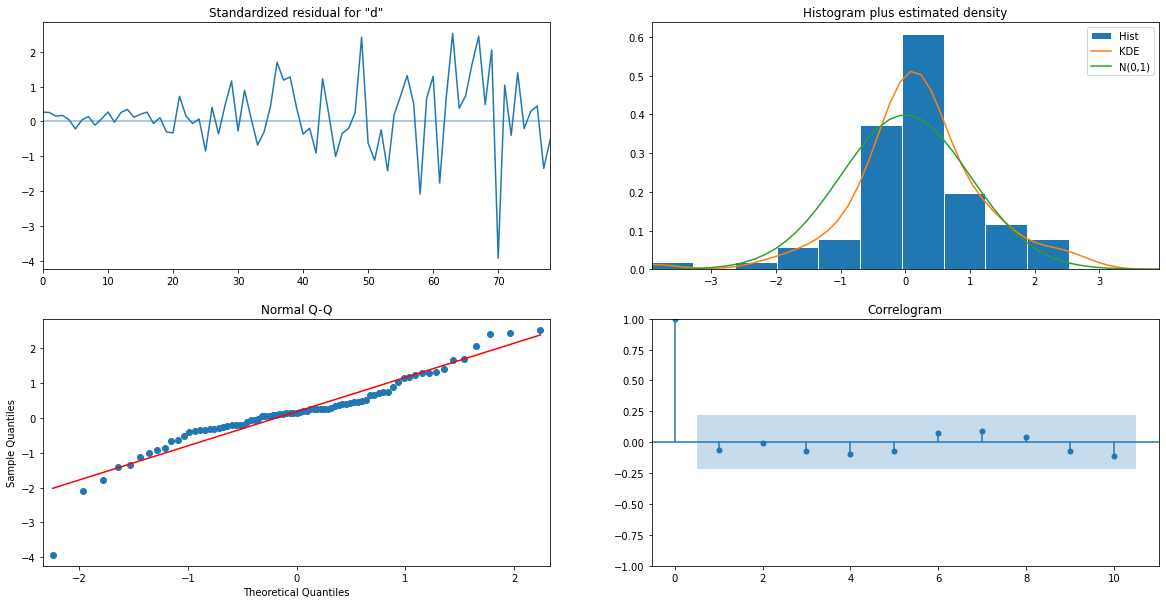

In [21]:
res.plot_diagnostics();

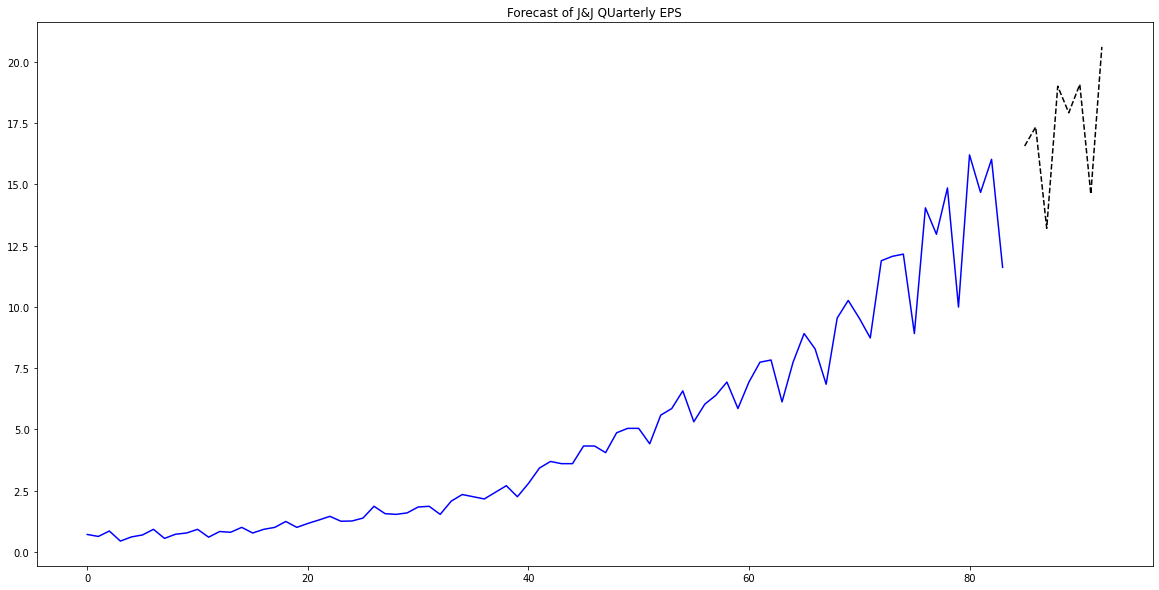

In [24]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of J&J QUarterly EPS')
plt.show()

In [25]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,data_tr_2,model
0,1960-01-01,0.71,NaN,NaN,0.000000
1,1960-04-01,0.63,-0.119545,NaN,0.710000
2,1960-07-02,0.85,0.299517,NaN,0.630000
3,1960-10-01,0.44,-0.658462,NaN,0.850000
4,1961-01-01,0.61,0.326684,NaN,0.795000
5,1961-04-02,0.69,0.123233,0.242778,0.530000
6,1961-07-02,0.92,0.287682,-0.011834,0.805039
7,1961-10-01,0.55,-0.514455,0.144006,0.482684
8,1962-01-01,0.72,0.269333,-0.057351,0.645186
9,1962-04-02,0.77,0.067139,-0.056093,0.748625


In [26]:
mse = mean_squared_error(data['data'], data['model'])

print(f'MSE: {mse}')

MSE: 0.15612774835049695


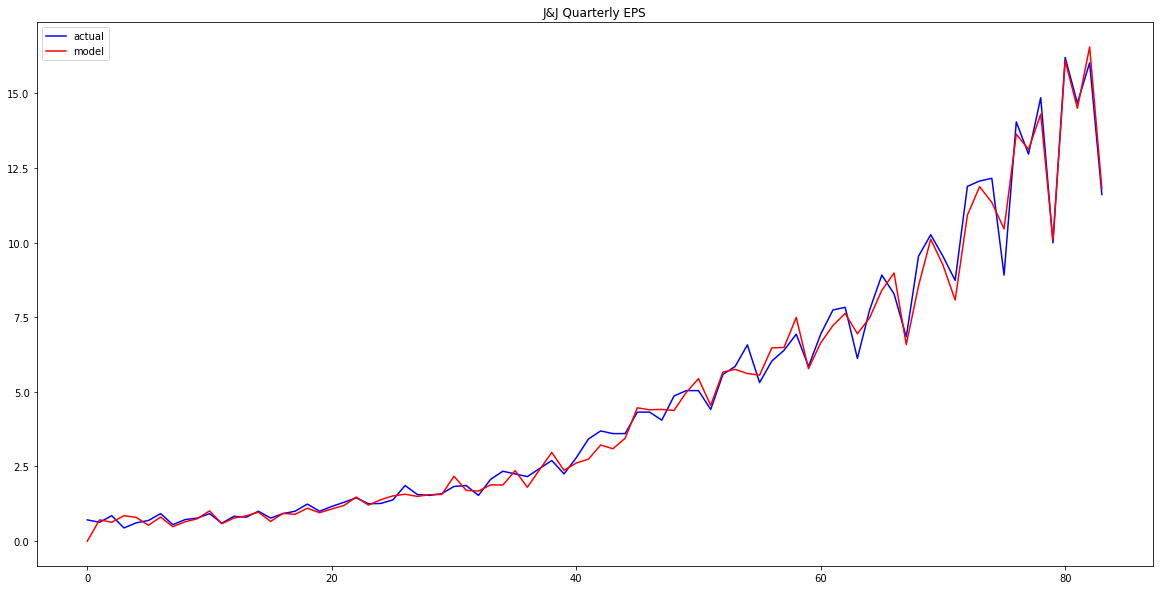

In [27]:
plt.plot(
    data['data'],
    color='blue',
    label='actual'
)
plt.plot(
    data['model'],
    color='red',
    label='model'
)
plt.legend(loc='best')
plt.title('J&J Quarterly EPS')
plt.show()